# 1) INTRODUCTION
Mr. X, a food technologist, manufactures and supplies tea and coffee dispenser machine to food eateries in the most common venues in the **Central district** of Delhi and makes good profit. 
He supplies to the most common venues as they attract the maximum customers resulting in higher profits and good branding for his products for future growth. 
To play safe he is thinking of checking the similarity between different districts of Delhi & expand his business in the district that is most similar to Central Delhi.
So to check the similarity between different districts of Delhi, considering **both the population as well as the most common venues** is important.

## Aim: 
#### To perform K Means to cluster different districts based on their population & most common food venues & select the most appropriate district for business expansion.

#### The target audience is Mr. X.

# 2) DATA 
####  - The data on population in each of the 11 districts has been extracted from https://www.nriol.com/india-statistics/delhi/districts.asp using BeautifulSoup library & the unnecessary columns are dropped from the table. The population is normalized to get the population fraction.
####  - Foursquare API is used to get the nearby venues in each of the districts with the help of the location coordinates. The top 20 most common venues for each district are then displayed using one-hot encoding.

Installing and importing necessary libraries

In [1]:
!pip install beautifulsoup4
!pip install lxml
import requests # library to handle requests
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 


from IPython.display import display_html
import pandas as pd
import numpy as np
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Folium installed')
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    ------------------------------------------------------------
                       

##### Scraping List of Districts table using BeautifulSoup

In [15]:
source = requests.get('https://www.nriol.com/india-statistics/delhi/districts.asp').text
soup=BeautifulSoup(source,'lxml')
print(soup.title)
tab = str(soup.table)
df = pd.read_html(tab)[0]
df

<title>List of Districts of Delhi </title>


,No.,Name of District,Area (sq km),Population,Name of Head Quarters
0,1,Central Delhi,23,578671,Daryaganj
1,2,North Delhi,59,883418,Sadar Bazaar
2,3,South Delhi,249,2733752,Saket
3,4,East Delhi,49,1707725,Preet Vihar
4,5,North East Delhi,56,2240749,Shahdara
5,6,South West Delhi,421,2292363,Palam
6,7,New Delhi,35,133713,Connaught Place
7,8,North West Delhi,2344,3651261,Kanjhawala
8,9,West Delhi,131,2531583,Rajouri Garden
9,10,Shahdara,------,322931,Shahdara


In [16]:
# Drop the unnecessary columns
df.drop(["No.","Area (sq km)","Name of Head Quarters"],axis=1,inplace=True)
df.iloc[10, 0 ] = "South East Delhi"
df

,Name of District,Population
0,Central Delhi,578671
1,North Delhi,883418
2,South Delhi,2733752
3,East Delhi,1707725
4,North East Delhi,2240749
5,South West Delhi,2292363
6,New Delhi,133713
7,North West Delhi,3651261
8,West Delhi,2531583
9,Shahdara,322931


#### Normalizing population by taking the population fraction

In [81]:
#Using latitude and longitude values of each district and merging it with the districts table
latitude =[28.6643,28.7886,28.4817,28.6280,28.7184,28.5929,28.6139,28.7186,28.6663,28.6894,28.5630]
longitude =[77.2167,77.1412,77.1873,77.2956,77.2580,77.0346,77.2090,77.0685,77.0680,77.2919,77.2611]
df['Latitude'] = latitude
df['Longitude'] = longitude

#Normalizing population by taking the population fraction
df['Population'] = df['Population']/df['Population'].sum()
df

,Name of District,Population,Latitude,Longitude
0,Central Delhi,0.032668,28.6643,77.2167
1,North Delhi,0.049871,28.7886,77.1412
2,South Delhi,0.154328,28.4817,77.1873
3,East Delhi,0.096406,28.6280,77.2956
4,North East Delhi,0.126496,28.7184,77.2580
5,South West Delhi,0.129410,28.5929,77.0346
6,New Delhi,0.007548,28.6139,77.2090
7,North West Delhi,0.206124,28.7186,77.0685
8,West Delhi,0.142915,28.6663,77.0680
9,Shahdara,0.018230,28.6894,77.2919


#### Entering client id, client secret, version, limit & radius 

In [82]:
CLIENT_ID = 'xxxxx'
CLIENT_SECRET = 'xxxxx'
VERSION = '20180605'
LIMIT = 100
radius = 5000 #5km

In [83]:
def get_category_type(row):
    try:
        categories_list = row['Categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Using Foursquare API

In [84]:
venues_list=[]
for lat, lng, district, population in zip(df['Latitude'],df['Longitude'],df['Name of District'], df['Population']):

            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        fsq_venues = json_normalize(results)
        
        # return only relevant information for each nearby venue
        columns = ['venue.id','venue.location.lat', 'venue.location.lng','venue.name','venue.categories']
        venues_df = fsq_venues[columns]
        venues_df['venue.categories'] = fsq_venues.apply(get_category_type, axis=1)
        venues_df['Name of District'] = district
        venues_df['Population'] = population
        
        venues_list.append(venues_df)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [85]:
delhi_venues = pd.concat(venues_list)
delhi_venues.head()

,venue.id,venue.location.lat,venue.location.lng,venue.name,venue.categories,Name of District,Population
0,4fe1cd59e4b00017d7fcbd78,28.662689,77.226300,Jolly Creations Designer Boutique,Boutique,Central Delhi,0.032668
1,4d9d759348b6224b70c2249f,28.658050,77.223377,Kake Di Hatti | काके दी हट्टी,Indian Restaurant,Central Delhi,0.032668
2,5662936e498e19a9801a663f,28.657325,77.224138,Amritsari Lassi Wala,Snack Place,Central Delhi,0.032668
3,56d96bfc498e2749a4ae6bf6,28.653247,77.232309,Haveli Dharampura,Hotel,Central Delhi,0.032668
4,5654478f498e405c3e4e0d6a,28.641451,77.215506,The Drunkyard Cafe,Tibetan Restaurant,Central Delhi,0.032668


In [86]:
delhi_venues.rename(columns = {'venue.id':'Venue ID', 'venue.location.lat':'Venue Latitude', 'venue.location.lng':'Venue Longitude', 'venue.name':'Venue Name', 'venue.categories': 'Venue Category' }, inplace =True)
delhi_venues.head()

,Venue ID,Venue Latitude,Venue Longitude,Venue Name,Venue Category,Name of District,Population
0,4fe1cd59e4b00017d7fcbd78,28.662689,77.226300,Jolly Creations Designer Boutique,Boutique,Central Delhi,0.032668
1,4d9d759348b6224b70c2249f,28.658050,77.223377,Kake Di Hatti | काके दी हट्टी,Indian Restaurant,Central Delhi,0.032668
2,5662936e498e19a9801a663f,28.657325,77.224138,Amritsari Lassi Wala,Snack Place,Central Delhi,0.032668
3,56d96bfc498e2749a4ae6bf6,28.653247,77.232309,Haveli Dharampura,Hotel,Central Delhi,0.032668
4,5654478f498e405c3e4e0d6a,28.641451,77.215506,The Drunkyard Cafe,Tibetan Restaurant,Central Delhi,0.032668


In [87]:
delhi_venues['Venue Category'].value_counts()

Indian Restaurant                  54
Café                               45
Hotel                              40
Fast Food Restaurant               31
Pizza Place                        29
Coffee Shop                        22
Restaurant                         16
Italian Restaurant                 13
Chinese Restaurant                 12
Market                             11
Lounge                             10
Bakery                              9
Shopping Mall                       8
BBQ Joint                           8
Donut Shop                          8
Bar                                 7
Asian Restaurant                    7
Food Truck                          6
Stadium                             6
Dessert Shop                        6
Park                                6
South Indian Restaurant             6
Arcade                              6
Department Store                    5
Monument / Landmark                 5
Tibetan Restaurant                  5
Sandwich Pla

#### Keeping only the venues related to food outlets

In [88]:
delhi_venues = delhi_venues[delhi_venues['Venue Category'].isin(['Asian Restaurant',
'Bakery',
'Bar',
'BBQ Joint',
'Beer Garden',
'Bengali Restaurant',
'Bistro',
'Breakfast Spot',
'Burger Joint',
'Burrito Place',
'Café',
'Chinese Restaurant',
'Cocktail Bar',
'Coffee Shop',
'Department Store',
'Dessert Shop',
'Diner',
'Donut Shop',
'Dumpling Restaurant',
'English Restaurant',
'Fast Food Restaurant',
'Food',
'Food & Drink Shop',
'Food Court',
'Food Truck',
'French Restaurant',
'Fried Chicken Joint',
'Gastropub',
'Hotel Bar',
'Ice Cream Shop',
'Indian Restaurant',
'Irani Cafe',
'Italian Restaurant',
'Japanese Restaurant',
'Karnataka Restaurant',
'Lounge',
'Mediterranean Restaurant',
'Middle Eastern Restaurant',
'Molecular Gastronomy Restaurant',
'Mughlai Restaurant',
'North Indian Restaurant',
'Northeast Indian Restaurant',
'Pizza Place',
'Portuguese Restaurant',
'Pub',
'Restaurant',
'Sandwich Place',
'Snack Place',
'South Indian Restaurant',
'Thai Restaurant',
'Tibetan Restaurant']
)]                                                                                                                         
                                                                             
delhi_venues.head()

,Venue ID,Venue Latitude,Venue Longitude,Venue Name,Venue Category,Name of District,Population
1,4d9d759348b6224b70c2249f,28.658050,77.223377,Kake Di Hatti | काके दी हट्टी,Indian Restaurant,Central Delhi,0.032668
2,5662936e498e19a9801a663f,28.657325,77.224138,Amritsari Lassi Wala,Snack Place,Central Delhi,0.032668
4,5654478f498e405c3e4e0d6a,28.641451,77.215506,The Drunkyard Cafe,Tibetan Restaurant,Central Delhi,0.032668
6,54783eab498e910f8bd1781d,28.634455,77.222139,Naturals Ice Cream,Ice Cream Shop,Central Delhi,0.032668
7,513a1684e4b0581da224735e,28.693245,77.204948,Big Yellow Door,Café,Central Delhi,0.032668


#### Performing One-hot encoding to convert categorical variables to discrete numerical variables

In [153]:
delhi_onehot = pd.get_dummies(delhi_venues[['Venue Category']], prefix = "", prefix_sep = "")
delhi_onehot['Name of District'] = delhi_venues['Name of District']
delhi_onehot['Population'] = delhi_venues['Population']
first_col = delhi_onehot.pop('Population')
delhi_onehot.insert(0, 'Population', first_col)
first_col = delhi_onehot.pop('Name of District')
delhi_onehot.insert(0, 'Name of District', first_col)
delhi_onehot.head()

,Name of District,Population,Asian Restaurant,BBQ Joint,Bakery,Bar,Bengali Restaurant,Bistro,Breakfast Spot,Café,Chinese Restaurant,Cocktail Bar,Coffee Shop,Department Store,Dessert Shop,Donut Shop,Dumpling Restaurant,English Restaurant,Fast Food Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Hotel Bar,Ice Cream Shop,Indian Restaurant,Irani Cafe,Italian Restaurant,Japanese Restaurant,Karnataka Restaurant,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Mughlai Restaurant,North Indian Restaurant,Northeast Indian Restaurant,Pizza Place,Pub,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Thai Restaurant,Tibetan Restaurant
1,Central Delhi,0.032668,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Central Delhi,0.032668,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,Central Delhi,0.032668,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,Central Delhi,0.032668,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Central Delhi,0.032668,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [91]:
delhi_onehot.shape

(362, 48)

#### Taking the mean of the frequencies of occurences of each venue

In [92]:
delhi_grouped = delhi_onehot.groupby('Name of District').mean().reset_index()
delhi_grouped

,Name of District,Population,Asian Restaurant,BBQ Joint,Bakery,Bar,Bengali Restaurant,Bistro,Breakfast Spot,Café,Chinese Restaurant,Cocktail Bar,Coffee Shop,Department Store,Dessert Shop,Donut Shop,Dumpling Restaurant,English Restaurant,Fast Food Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Hotel Bar,Ice Cream Shop,Indian Restaurant,Irani Cafe,Italian Restaurant,Japanese Restaurant,Karnataka Restaurant,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Mughlai Restaurant,North Indian Restaurant,Northeast Indian Restaurant,Pizza Place,Pub,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Thai Restaurant,Tibetan Restaurant
0,Central Delhi,0.032668,0.013514,0.013514,0.040541,0.027027,0.000000,0.013514,0.027027,0.121622,0.027027,0.000000,0.054054,0.013514,0.013514,0.040541,0.013514,0.000000,0.094595,0.013514,0.027027,0.000000,0.013514,0.000000,0.000000,0.013514,0.000000,0.013514,0.148649,0.000000,0.000000,0.000000,0.000000,0.054054,0.000000,0.000000,0.013514,0.000000,0.013514,0.000000,0.040541,0.000000,0.013514,0.013514,0.054054,0.027027,0.000000,0.027027
1,East Delhi,0.096406,0.023810,0.023810,0.023810,0.000000,0.000000,0.000000,0.000000,0.119048,0.023810,0.000000,0.047619,0.023810,0.023810,0.000000,0.000000,0.000000,0.071429,0.000000,0.023810,0.023810,0.023810,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.023810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023810,0.000000,0.285714,0.000000,0.023810,0.023810,0.000000,0.023810,0.000000,0.000000
2,New Delhi,0.007548,0.015385,0.030769,0.030769,0.046154,0.000000,0.015385,0.000000,0.169231,0.030769,0.015385,0.030769,0.000000,0.000000,0.000000,0.000000,0.015385,0.000000,0.000000,0.000000,0.000000,0.015385,0.015385,0.000000,0.015385,0.030769,0.015385,0.215385,0.015385,0.015385,0.015385,0.015385,0.061538,0.030769,0.000000,0.015385,0.000000,0.030769,0.015385,0.000000,0.000000,0.030769,0.000000,0.000000,0.030769,0.000000,0.015385
3,North East Delhi,0.126496,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000
4,North West Delhi,0.206124,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Shahdara,0.018230,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,South Delhi,0.154328,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.176471,0.000000,0.000000,0.117647,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.235294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.117647,0.000000,0.000000,0.000000,0.000000,0.117647,0.000000
7,South East Delhi,0.036004,0.013699,0.013699,0.041096,0.027397,0.013699,0.000000,0.000000,0.095890,0.054795,0.000000,0.054795,0.000000,0.041096,0.013699,0.000000,0.013699,0.068493,0.013699,0.0000

## Note that there are no eateries in North Delhi

#### Displaying the top 20 most common venues for each district

In [186]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    return row_categories_sorted.index.values[0:num_top_venues]

#To create new dataframe & display top 10 venues for each district
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Name of District', 'Population']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1,indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
districts_venues_sorted = pd.DataFrame(columns = columns)
districts_venues_sorted['Name of District'] = delhi_grouped['Name of District']
districts_venues_sorted['Population'] = delhi_grouped['Population']
for ind in np.arange(delhi_grouped.shape[0]):
    districts_venues_sorted.iloc[ind, 2:] = return_most_common_venues(delhi_grouped.iloc[ind, :], num_top_venues)
districts_venues_sorted

,Name of District,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Delhi,0.032668,Indian Restaurant,Café,Fast Food Restaurant,Snack Place,Lounge,Coffee Shop,Bakery,Donut Shop,Pizza Place,Tibetan Restaurant
1,East Delhi,0.096406,Pizza Place,Indian Restaurant,Café,Fast Food Restaurant,Coffee Shop,Asian Restaurant,Food Court,Food Truck,Dessert Shop,Department Store
2,New Delhi,0.007548,Indian Restaurant,Café,Lounge,Bar,Mediterranean Restaurant,Coffee Shop,Hotel Bar,North Indian Restaurant,Chinese Restaurant,Restaurant
3,North East Delhi,0.126496,Tibetan Restaurant,Restaurant,Café,Coffee Shop,Asian Restaurant,Sandwich Place,Food Court,Food,Fast Food Restaurant,English Restaurant
4,North West Delhi,0.206124,Indian Restaurant,Fast Food Restaurant,Department Store,Pizza Place,Tibetan Restaurant,Food Court,Food & Drink Shop,Food,English Restaurant,Dumpling Restaurant
5,Shahdara,0.018230,Pizza Place,Food Truck,Dessert Shop,BBQ Joint,Fast Food Restaurant,Café,Italian Restaurant,Food Court,Food & Drink Shop,Food
6,South Delhi,0.154328,Italian Restaurant,Café,Coffee Shop,Thai Restaurant,Pub,Indian Restaurant,Donut Shop,Food Truck,Asian Restaurant,Breakfast Spot
7,South East Delhi,0.036004,Indian Restaurant,Restaurant,Café,Italian Restaurant,Fast Food Restaurant,Chinese Restaurant,Coffee Shop,Bakery,Dessert Shop,Japanese Restaurant
8,South West Delhi,0.129410,Fast Food Restaurant,Indian Restaurant,Café,Pizza Place,Fried Chicken Joint,Chinese Restaurant,Cocktail Bar,Coffee Shop,Asian Restaurant,Restaurant
9,West Delhi,0.142915,Fast Food Restaurant,Coffee Shop,Pizza Place,Indian Restaurant,Café,Restaurant,Donut Shop,Department Store,BBQ Joint,Sandwich Place


# 3) METHODOLOGY
#### I have used K Means for making clusters based on population & most common venues. The elbow point is determined to get the optimal value of K.
#### I have plotted these clusters on the map of Delhi using Folium.


## K Means
Ekbow point

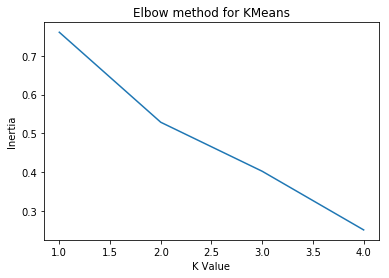

In [183]:
sum_squared_distance=[]

for k in range(1,5):
    kmeans=KMeans(n_clusters=k).fit(df_clustering)
    kmeans.predict(df_clustering)
    sum_squared_distance.append(kmeans.inertia_)

#Let's plot the graph now to find the optimal 'k'

plt.plot(range(1,5),sum_squared_distance)
plt.title("Elbow method for KMeans")
plt.xlabel("K Value")
plt.ylabel("Inertia")
plt.show()

Grouping into 2 clusters

In [187]:
df_clustering = delhi_grouped.drop('Name of District', 1)

In [188]:
k = 2
kmeans = KMeans(n_clusters = k, random_state = 0)
kmeans.fit(df_clustering)
kmeans.labels_[0:10]

array([0, 1, 0, 0, 1, 1, 0, 0, 1, 1], dtype=int32)

In [189]:
districts_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)

In [190]:
delhi_merged = df[df['Name of District'] != 'North Delhi']
delhi_merged = delhi_merged.drop('Population', axis = 1)
# merge to add latitude/longitude for each neighborhood
delhi_merged = delhi_merged.join(districts_venues_sorted.set_index('Name of District'), on='Name of District')
delhi_merged = delhi_merged.dropna()
delhi_merged

,Name of District,Latitude,Longitude,Cluster Label,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Delhi,28.6643,77.2167,0,0.032668,Indian Restaurant,Café,Fast Food Restaurant,Snack Place,Lounge,Coffee Shop,Bakery,Donut Shop,Pizza Place,Tibetan Restaurant
2,South Delhi,28.4817,77.1873,0,0.154328,Italian Restaurant,Café,Coffee Shop,Thai Restaurant,Pub,Indian Restaurant,Donut Shop,Food Truck,Asian Restaurant,Breakfast Spot
3,East Delhi,28.6280,77.2956,1,0.096406,Pizza Place,Indian Restaurant,Café,Fast Food Restaurant,Coffee Shop,Asian Restaurant,Food Court,Food Truck,Dessert Shop,Department Store
4,North East Delhi,28.7184,77.2580,0,0.126496,Tibetan Restaurant,Restaurant,Café,Coffee Shop,Asian Restaurant,Sandwich Place,Food Court,Food,Fast Food Restaurant,English Restaurant
5,South West Delhi,28.5929,77.0346,1,0.129410,Fast Food Restaurant,Indian Restaurant,Café,Pizza Place,Fried Chicken Joint,Chinese Restaurant,Cocktail Bar,Coffee Shop,Asian Restaurant,Restaurant
6,New Delhi,28.6139,77.2090,0,0.007548,Indian Restaurant,Café,Lounge,Bar,Mediterranean Restaurant,Coffee Shop,Hotel Bar,North Indian Restaurant,Chinese Restaurant,Restaurant
7,North West Delhi,28.7186,77.0685,1,0.206124,Indian Restaurant,Fast Food Restaurant,Department Store,Pizza Place,Tibetan Restaurant,Food Court,Food & Drink Shop,Food,English Restaurant,Dumpling Restaurant
8,West Delhi,28.6663,77.0680,1,0.142915,Fast Food Restaurant,Coffee Shop,Pizza Place,Indian Restaurant,Café,Restaurant,Donut Shop,Department Store,BBQ Joint,Sandwich Place
9,Shahdara,28.6894,77.2919,1,0.018230,Pizza Place,Food Truck,Dessert Shop,BBQ Joint,Fast Food Restaurant,Café,Italian Restaurant,Food Court,Food & Drink Shop,Food
10,South East Delhi,28.5630,77.2611,0,0.036004,Indian Restaurant,Restaurant,Café,Italian Restaurant,Fast Food Restaurant,Chinese Restaurant,Coffee Shop,Bakery,Dessert Shop,Japanese Restaurant


## Making Map

In [191]:
map_clusters = folium.Map(location = [28.7041,77.1025], zoom_start = 10)
#Set color for clusters:
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0,1,len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#Add markers
for lat, lng, poi, cluster in zip(delhi_merged['Latitude'], delhi_merged['Longitude'], delhi_merged['Name of District'], delhi_merged['Cluster Label']):
    label = folium.Popup(str(poi) + 'Cluster' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat,lng],
        radius = 5,
        popup = label,
        color = rainbow[cluster - 1],
        fill = True,
        fill_color = rainbow[cluster - 1],
        fill_opacity = 0.7).add_to(map_clusters)
map_clusters

## Cluster 1

In [192]:
delhi_merged.loc[delhi_merged['Cluster Label'] == 0, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]

,Name of District,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Delhi,0.032668,Indian Restaurant,Café,Fast Food Restaurant,Snack Place,Lounge,Coffee Shop,Bakery,Donut Shop,Pizza Place,Tibetan Restaurant
2,South Delhi,0.154328,Italian Restaurant,Café,Coffee Shop,Thai Restaurant,Pub,Indian Restaurant,Donut Shop,Food Truck,Asian Restaurant,Breakfast Spot
4,North East Delhi,0.126496,Tibetan Restaurant,Restaurant,Café,Coffee Shop,Asian Restaurant,Sandwich Place,Food Court,Food,Fast Food Restaurant,English Restaurant
6,New Delhi,0.007548,Indian Restaurant,Café,Lounge,Bar,Mediterranean Restaurant,Coffee Shop,Hotel Bar,North Indian Restaurant,Chinese Restaurant,Restaurant
10,South East Delhi,0.036004,Indian Restaurant,Restaurant,Café,Italian Restaurant,Fast Food Restaurant,Chinese Restaurant,Coffee Shop,Bakery,Dessert Shop,Japanese Restaurant


## Cluster 2

In [193]:
delhi_merged.loc[delhi_merged['Cluster Label'] == 1, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]

,Name of District,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,East Delhi,0.096406,Pizza Place,Indian Restaurant,Café,Fast Food Restaurant,Coffee Shop,Asian Restaurant,Food Court,Food Truck,Dessert Shop,Department Store
5,South West Delhi,0.129410,Fast Food Restaurant,Indian Restaurant,Café,Pizza Place,Fried Chicken Joint,Chinese Restaurant,Cocktail Bar,Coffee Shop,Asian Restaurant,Restaurant
7,North West Delhi,0.206124,Indian Restaurant,Fast Food Restaurant,Department Store,Pizza Place,Tibetan Restaurant,Food Court,Food & Drink Shop,Food,English Restaurant,Dumpling Restaurant
8,West Delhi,0.142915,Fast Food Restaurant,Coffee Shop,Pizza Place,Indian Restaurant,Café,Restaurant,Donut Shop,Department Store,BBQ Joint,Sandwich Place
9,Shahdara,0.018230,Pizza Place,Food Truck,Dessert Shop,BBQ Joint,Fast Food Restaurant,Café,Italian Restaurant,Food Court,Food & Drink Shop,Food


# 4) RESULT
#### The 1st cluster consists of the following districts:- Central Delhi, South Delhi, North East Delhi, New Delhi & South East Delhi
#### The 3rd cluster consists of the following districts:-  East Delhi, South West Delhi, North West Delhi, West Delhi & Shahdara

#### We are interested in the cluster having "Central Delhi"
 - In **Central Delhi**, most common are Indian Restaurant, Café & Fast Food Restaurant.
 - In **South Delhi**, most common are Italian Restaurant, Café & Coffee Shop.
 - In **North East Delhi**, most common are Tibetan Restaurant, Restaurant & Café.
 - In **New Delhi**, most common are Indian Restaurant, Café & Lounge.
 - In **South East Delhi**, most common are Indian Restaurant, Restaurant & Café.

Also, the district with the highest population among these 5 is **South Delhi**

Now, **New Delhi District** has similar top 2 most common eateries but the population is way lesser than **Central Delhi**. This means that even the most common venues would not be having enough footfall.





# 5) DISCUSSION
If we look at all the common venues, it is clearly evident that **South East Delhi** has 5 similar venues as **Central Delhi**. Also it has the **similar population** as Central Delhi.

So, Mr. X can expand his business in **South East Delhi**.

# 6) CONCLUSION
The purpose of this project was to explore the different districts of Delhi keeping in mind population & nearby food eateries. 

One of the limitations of this project is that I have assigned the population in the district to each food outlet in the district. However, each district of Delhi is quite big in size and needs to be broken down to neighborhoods to get a more accurate representation but neighborhood level population data was not available for Delhi.

Therefore, with the available information, it is safe to conclude that **South East Delhi** would be the best option for Mr. X. 

# THANK YOU!